#CIFAR10 Image Classification

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

#Carichiamo i dati del dataset CIFAR-10

In [5]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


#Visualizziamo le prime 30 immagini di addestramento

In [6]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [7]:
num_classes = len(cifar10_labels)

In [8]:
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

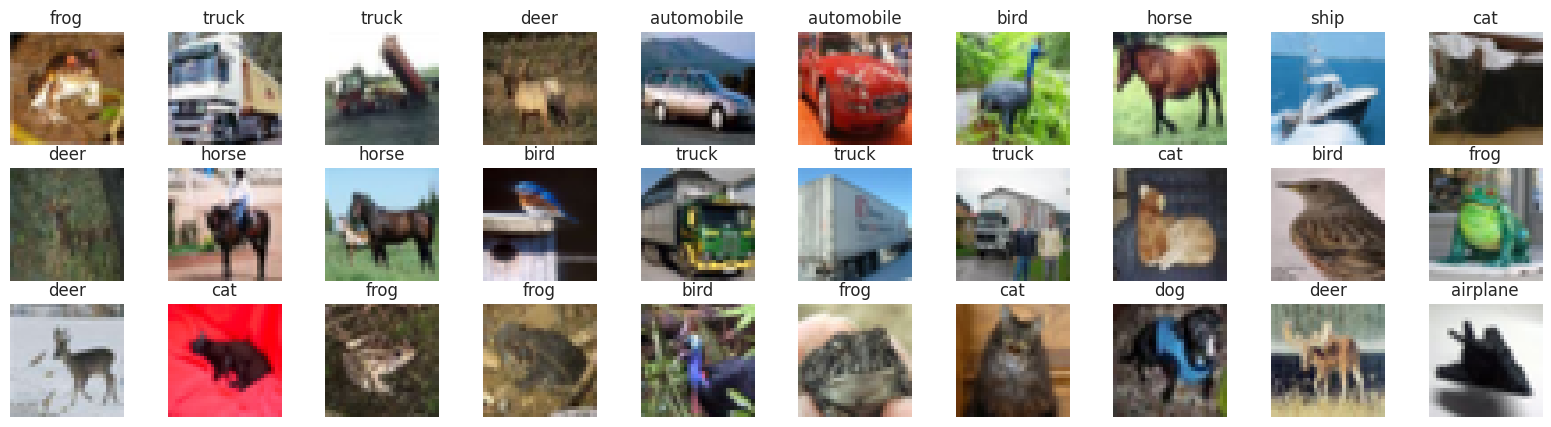

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])


In [10]:
#ridimensioniamo le immagini
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [11]:
#train-test split
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

In [12]:
# shape of training set
X_train.shape

(45000, 32, 32, 3)

In [13]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


#Feeforward Neural Network

Per prima cosa addestriamo una rete feedforward a due strati su 50.000 campioni di addestramento per 20 epoche per ottenere un'accuratezza del test del 44,22%. Sperimentiamo anche una rete convoluzionale a tre strati con 500K parametri per una test accuracy del 67,07%.

In [16]:
#architettura del modello
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

In [17]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1000)              3073000   
                                                                 
 droput_1 (Dropout)          (None, 1000)              0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)               512512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 3,590,642
Trainable params: 3,590,642
Non-

In [18]:
#compiliamo il modello
mlp.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
#definiamo le callbacks
results_path = Path('content', 'drive')
mlp_path = (results_path / 'mlp.weights.best.hdf5').as_posix()

In [49]:
#train the model
batch_size = 32
epochs = 100

In [52]:
checkpointer = ModelCheckpoint(filepath=mlp_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'mlp',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [53]:
mlp_history = mlp.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=1,
                      shuffle=True)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 1.9395 - accuracy: 0.2889
Epoch 1: val_accuracy improved from -inf to 0.34420, saving model to content/drive/mlp.weights.best.hdf5
1250/1250 [==============================] - 70s 55ms/step - loss: 1.9395 - accuracy: 0.2889 - val_loss: 1.7912 - val_accuracy: 0.3442
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 1.7649 - accuracy: 0.3602
Epoch 2: val_accuracy improved from 0.34420 to 0.38600, saving model to content/drive/mlp.weights.best.hdf5
1250/1250 [==============================] - 70s 56ms/step - loss: 1.7649 - accuracy: 0.3602 - val_loss: 1.6951 - val_accuracy: 0.3860
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 1.6940 - accuracy: 0.3889
Epoch 3: val_accuracy improved from 0.38600 to 0.39820, saving model to content/drive/mlp.weights.best.hdf5
1250/1250 [==============================] - 65s 52ms/step - loss: 1.6940 - accuracy: 0.3889 - val_loss: 1.6519 

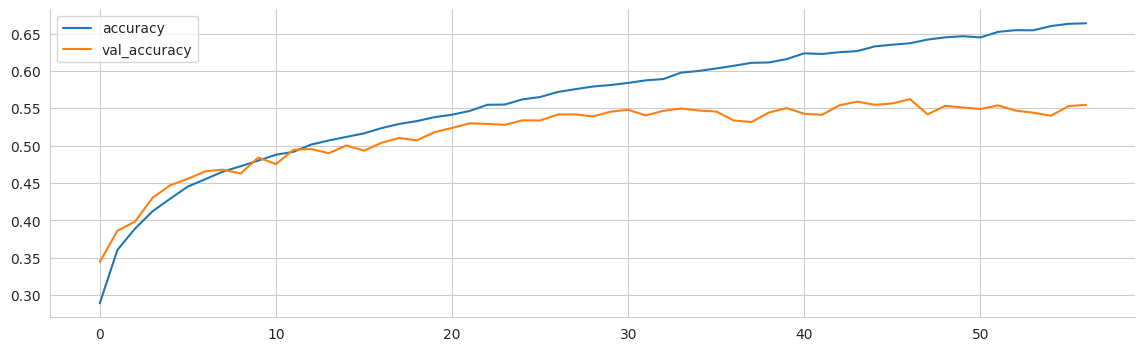

In [54]:
#plot i risultati
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine()

In [55]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

In [56]:
#valutazione della test accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(mlp_accuracy))

Test accuracy: 55.43%


#Convolutional Neural Network

In [70]:
K.clear_session()

In [103]:
#architettura dle modello
cnn = Sequential([
    Conv2D(filters=16,
           kernel_size=2,
           padding='same',
           activation='relu',
           input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

In [104]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 32, 32, 16)        208       
                                                                 
 POOL1 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 CONV2 (Conv2D)              (None, 16, 16, 32)        2080      
                                                                 
 POOL2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 CONV3 (Conv2D)              (None, 8, 8, 64)          8256      
                                                                 
 POOL3 (MaxPooling2D)        (None, 4, 4, 64)          0         
                                                                 
 DROP1 (Dropout)             (None, 4, 4, 64)         

In [105]:
#compiliamo il modello
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [106]:
#definiamo le callbacks
from google.colab import drive
drive.mount('/content/gdrive')
results_path = Path('content', 'drive')
cnn_path = (results_path / 'cnn.weights.best.hdf5').as_posix()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [107]:
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [108]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [109]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [110]:
#train the model
batch_size = 32
epochs = 100

In [111]:
cnn_history = cnn.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2,
                      shuffle=True)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.53080, saving model to content/drive/cnn.weights.best.hdf5
1407/1407 - 50s - loss: 1.5742 - accuracy: 0.4260 - val_loss: 1.2997 - val_accuracy: 0.5308 - 50s/epoch - 35ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.53080 to 0.60960, saving model to content/drive/cnn.weights.best.hdf5
1407/1407 - 50s - loss: 1.2801 - accuracy: 0.5407 - val_loss: 1.1255 - val_accuracy: 0.6096 - 50s/epoch - 35ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.60960 to 0.62820, saving model to content/drive/cnn.weights.best.hdf5
1407/1407 - 50s - loss: 1.1608 - accuracy: 0.5868 - val_loss: 1.0444 - val_accuracy: 0.6282 - 50s/epoch - 35ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.62820 to 0.64600, saving model to content/drive/cnn.weights.best.hdf5
1407/1407 - 50s - loss: 1.0754 - accuracy: 0.6166 - val_loss: 1.0025 - val_accuracy: 0.6460 - 50s/epoch - 35ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.6460

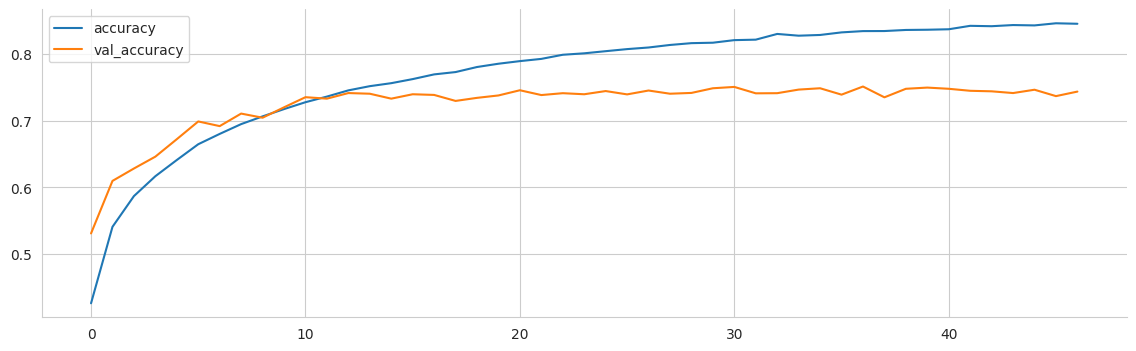

In [112]:
#plot dei risultati
pd.DataFrame(cnn_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

In [113]:
#carichiamo il miglior modello
cnn.load_weights(cnn_path)

In [114]:
#accuratezza del set di test
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(cnn_accuracy))

Accuracy: 73.75%


#Valutiamo le previsioni

In [115]:
y_hat = cnn.predict(X_test)

313/313 [==============================] - 4s 11ms/step


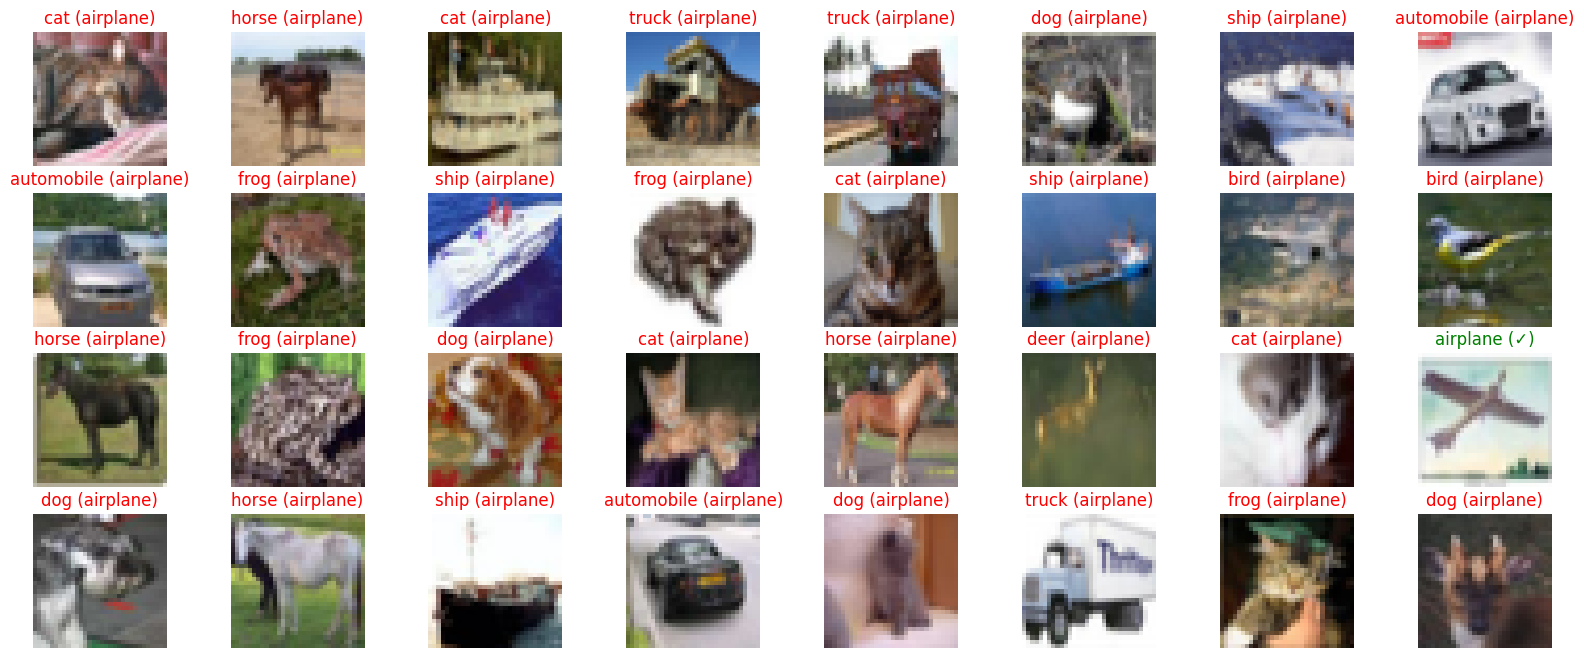

In [116]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx],
                                      cifar10_labels[true_idx]),
                     color='red')

#CNN con Image Augmentation

creiamo e configuriamo il generatore di immagini aumentate

In [117]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

In [118]:
# fit augmented image generator on data
datagen.fit(X_train)

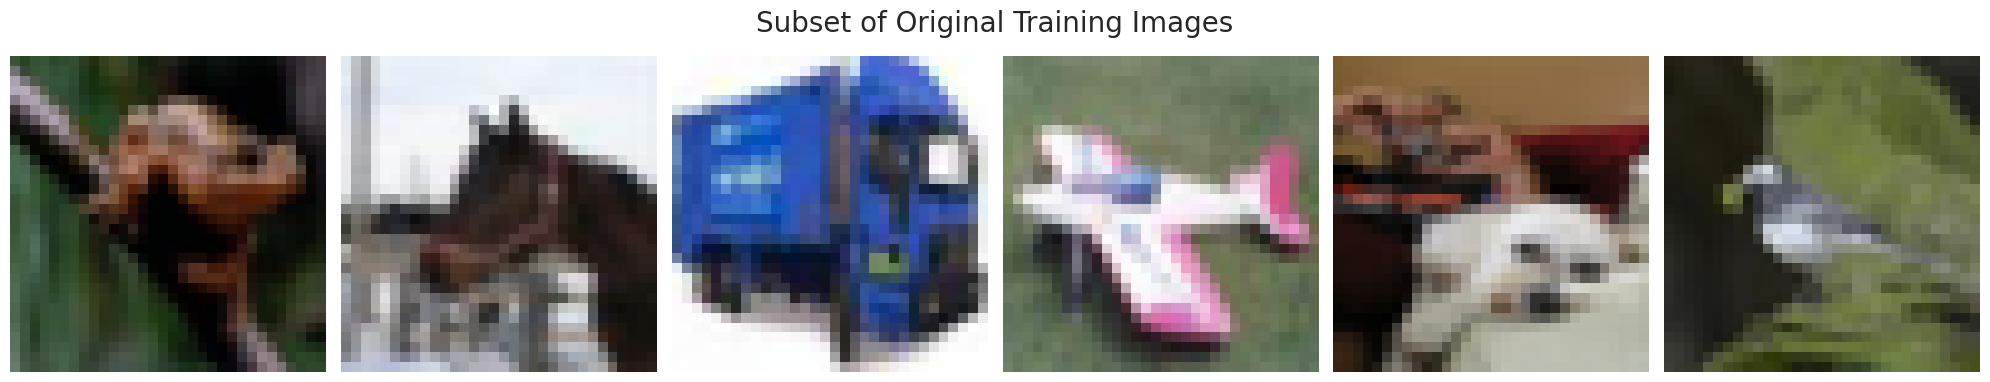

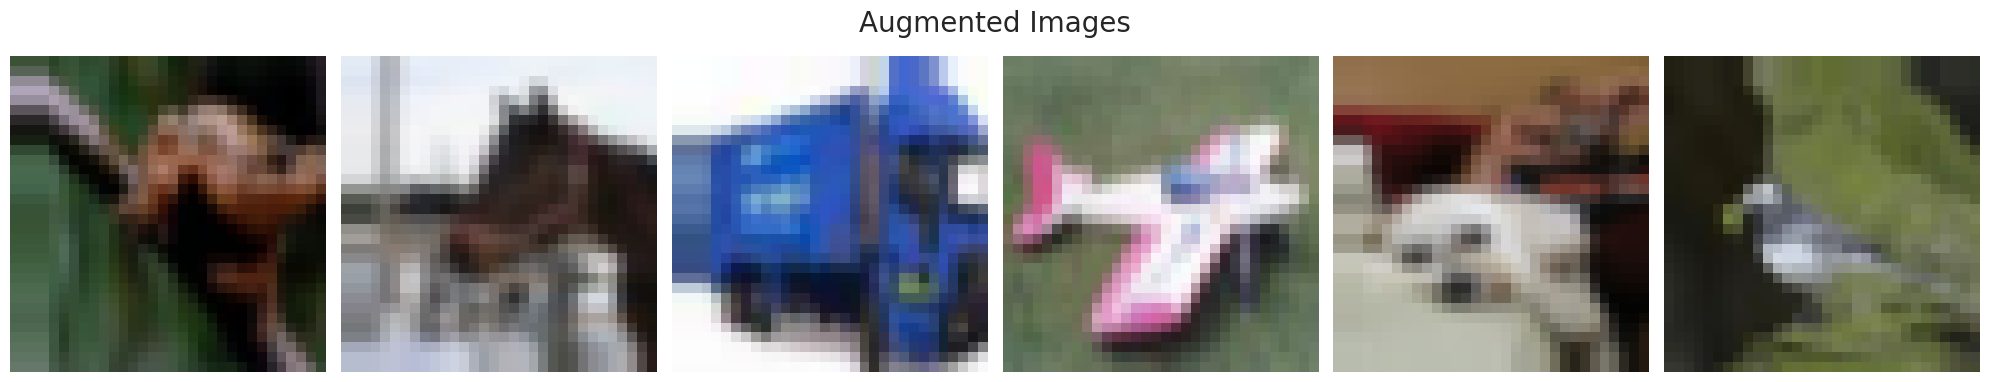

In [119]:
#visualizziamo un sottoinsieme dei dati di addestramento
n_images = 6
x_train_subset = X_train[:n_images]

# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'original_images')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images,
                            shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'augmented_images')

In [120]:
#definiamo le callbacks
K.clear_session()

cnn_aug_path = (results_path / 'augmented.cnn.weights.best.hdf5').as_posix()

checkpointer = ModelCheckpoint(filepath=cnn_aug_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn_aug',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

In [121]:
#train augmented images

batch_size = 32
epochs = 100

cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs,
                          validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.72660, saving model to content/drive/augmented.cnn.weights.best.hdf5
1406/1406 - 70s - loss: 1.0124 - accuracy: 0.6529 - val_loss: 0.8140 - val_accuracy: 0.7266 - 70s/epoch - 50ms/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.72660
1406/1406 - 69s - loss: 0.9671 - accuracy: 0.6651 - val_loss: 0.8516 - val_accuracy: 0.7022 - 69s/epoch - 49ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.72660
1406/1406 - 71s - loss: 0.9409 - accuracy: 0.6708 - val_loss: 0.8210 - val_accuracy: 0.7216 - 71s/epoch - 50ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.72660 to 0.74440, saving model to content/drive/augmented.cnn.weights.best.hdf5
1406/1406 - 71s - loss: 0.9174 - accuracy: 0.6812 - val_loss: 0.7444 - val_accuracy: 0.7444 - 71s/epoch - 50ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.74440
1406/1406 - 69s - loss: 0.9092 - accuracy: 0.6845 - val_loss: 0.7862 - val_accuracy: 

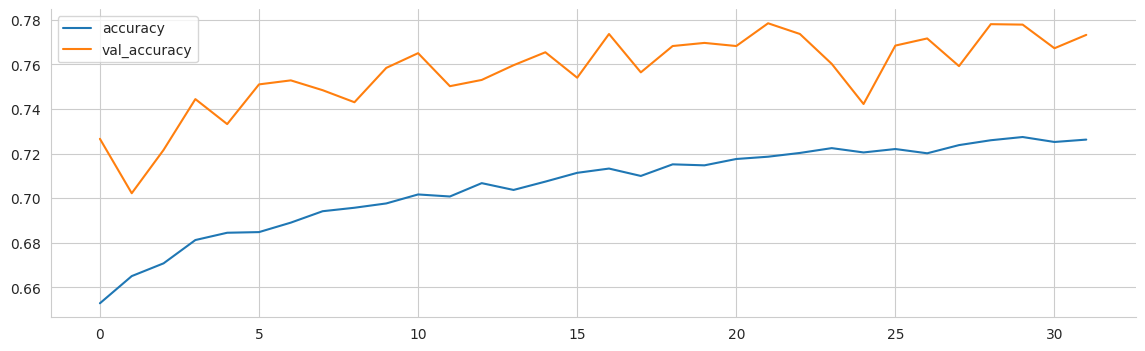

In [122]:
#plot dei risultati
pd.DataFrame(cnn_aug_history.history)[['accuracy',
                                       'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

In [123]:
#carichiamo il miglior modello
cnn.load_weights(cnn_aug_path)

In [124]:
#test accuracy
cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

Test Accuracy: 76.41%


#AlexNet

In [14]:
#definiamo l'achitettura


alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3, 3),
           strides=(2, 2),
           activation='relu',
           padding='same',
           input_shape=input_shape,
           name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(5, 5),
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [15]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 16, 16, 96)        2688      
                                                                 
 POOL_1 (MaxPooling2D)       (None, 8, 8, 96)          0         
                                                                 
 NORM_1 (BatchNormalization)  (None, 8, 8, 96)         384       
                                                                 
 CONV2 (Conv2D)              (None, 8, 8, 256)         614656    
                                                                 
 POOL2 (MaxPooling2D)        (None, 3, 3, 256)         0         
                                                                 
 NORM_2 (BatchNormalization)  (None, 3, 3, 256)        1024      
                                                                 
 CONV3 (Conv2D)              (None, 3, 3, 384)         8

In [16]:
#compiliamo il modello
alexnet.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [17]:
#definiamo le callbacks
from google.colab import drive
drive.mount('/content/gdrive')
results_path = Path('content', 'drive')

alexnet_path = (results_path / 'alexnet.weights.best.hdf5').as_posix()

checkpointer = ModelCheckpoint(filepath=alexnet_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'alexnet',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='max',
                               patience=10)

Mounted at /content/gdrive


In [18]:
#train model
batch_size = 32
epochs = 100

alex_history = alexnet.fit(X_train, 
                           y_train,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(X_valid, 
                                            y_valid),
                           callbacks=[checkpointer, 
                                      tensorboard, 
                                      early_stopping],
                           verbose=1)

Epoch 1/100
1140/1407 [=======================>......] - ETA: 2:21 - loss: 1.6502 - accuracy: 0.4103

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(alex_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 5))
sns.despine();

In [ ]:
alexnet.load_weights(alexnet_path)

In [ ]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(alex_accuracy))

#Confrontiamo i risultati

In [ ]:
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
        'CNN': pd.Series(cnn_history.history['val_accuracy']),
        'CNN Aug.': pd.Series(cnn_aug_history.history['val_accuracy']),
        'Alex Net': pd.Series(alex_history.history['val_accuracy'])
    })

In [ ]:
test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy
})

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
sns.despine()
fig.savefig(results_path / 'comparison', dpi=300);